# Ablation Studies

This notebook details the design and execution of ablation studies performed on a multi-agent system designed to solve Advent of Code puzzles. The system comprises several specialized AI agents, each responsible for a different stage of the problem-solving process: preprocessing, retrieval, planning, coding, and debugging.

Ablation studies are a technique used to understand the contribution of individual components to the overall performance of a system. In this context, we will systematically disable specific agents within the system to observe how their absence impacts the system's ability to solve Advent of Code puzzles.

The primary goal of these studies is to gain insights into the importance and effectiveness of each agent in the pipeline. By isolating the coding agent and disabling others in various combinations, we aim to identify which agents are most critical for successful problem-solving and how the interaction between agents influences the outcome.

Through these experiments, we hope to better understand the system's architecture, identify potential areas for improvement, and inform future development efforts.

**Agents in the System:**

*   **Preprocessing Agent:** Handles initial processing and understanding of the puzzle description.
*   **Retrieval Agent:** Responsible for retrieving relevant information, potentially from a knowledge base or past solutions.
*   **Planning Agent:** Develops strategies and plans for solving the puzzle.
*   **Coding Agent:** Generates the actual code solution based on the plan.
*   **Debugging Agent:** Identifies and fixes errors in the generated code.

In these ablation studies, the **Coding Agent will always remain enabled**, as it is essential for producing a code solution. The other agents will be selectively disabled to assess their impact.


## Setup

- Setup the model to use
- Load all the puzzles

In [3]:
import os
import sys
import dotenv
import json
from loguru import logger

# Append the models path in order to import the models
PROJECT_ROOT = os.path.join(os.getcwd(), 'src/')
print(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

# Load env variables
dotenv.load_dotenv()

# Set log level INFO
logger.remove()
logger.add(sys.stderr, level="INFO")

/home/twanh/workspace/thesis/thesis-advent-of-agents/src/


1

### Load puzzles and input/outputs

In [49]:
# Get the correct paths
test_data_folder = os.path.join(PROJECT_ROOT, '..', 'experiments', 'test_data')
puzzles_folder = os.path.join(test_data_folder, 'puzzles/')
input_output_file = os.path.join(test_data_folder, 'answers2024.json')
puzzle_files = [os.path.join(puzzles_folder, f) for f in os.listdir(puzzles_folder) if os.path.isfile(os.path.join(puzzles_folder, f))]

In [50]:
# Create a datastructure were we can get by day
json_data = {}
with open(input_output_file, 'r') as f:
    json_data = {item['day']: item for item in json.load(f)}

puzzle_data = []
for file_path in puzzle_files:
    # Get the day of the puzzle file
    file_name = os.path.basename(file_path)
    day_str = file_name.split('_')[-1].split('.')[0]
    day = int(day_str)

    if day in json_data:
        with open(file_path, 'r') as f:
            puzzle_description = f.read()

        puzzle_info = {
            "year": json_data[day]['year'],
            "day": day,
            "description": puzzle_description,
            "input": json_data[day]['input'],
            "expected_output": json_data[day]['part1']
        }

        puzzle_data.append(puzzle_info)

# Sort by day
puzzle_data.sort(key=lambda x: x['day'])
print(len(puzzle_data)) # should be 25

25


### Setup Ablation Configs

In [8]:
ablation_configs = [
    {
        "name": "baseline",
        "preprocess": True,
        "retrieval": True,
        "planning": True,
        "coding": True,
        "debugging": True
    },
    {
        "name": "disable_preprocessing",
        "preprocess": False,
        "retrieval": True,
        "planning": True,
        "coding": True,
        "debugging": True
    },
    {
        "name": "disable_retrieval",
        "preprocess": True,
        "retrieval": False,
        "planning": True,
        "coding": True,
        "debugging": True
    },
    {
        "name": "disable_planning",
        "preprocess": True,
        "retrieval": True,
        "planning": False,
        "coding": True,
        "debugging": True
    },
    {
        "name": "disable_debugging",
        "preprocess": True,
        "retrieval": True,
        "planning": True,
        "coding": True,
        "debugging": False
    }
]

## System

In [52]:
from agents.base_agent import BaseAgent
from agents.coding_agent import CodingAgent
from agents.debugging_agent import DebuggingAgent
from agents.planning_agent import PlanningAgent
from agents.pre_processing_agent import PreProcessingAgent
from agents.retreival_agent import RetrievalAgent
from core.orchestrator import Orchestrator
from utils.util_types import AgentSettings
from core.state import MainState
from utils.util_types import Puzzle
from models.base_model import BaseLanguageModel

In [53]:

def setup_system(config: dict[str, bool], model: BaseLanguageModel, expected_output: str, puzzle_input: str):

    agents = (
        (
            PreProcessingAgent(
                'preprocess', model=model,
            ),
            AgentSettings(enabled=config['preprocess'], can_debug=False),
        ),
        (
            RetrievalAgent(
                'retreival',
                model=model,
                connection_string=os.getenv('DB_CONNECTION_STRING') or '',
                openai_key=os.getenv('OPENAI_API_KEY') or '',
                weights=None, # Use default weights
            ),
            AgentSettings(enabled=config['retrieval'], can_debug=False),
        ),
        (
            PlanningAgent(
                'planning',
                model=model,
                n_plans=3, # Keep n_plans fixed for consistent comparison
            ),
            AgentSettings(enabled=config['planning'], can_debug=False),
        ),
        (
            CodingAgent('coding', model=model),
            AgentSettings(enabled=config['coding'], can_debug=False),
        ),
        (
            DebuggingAgent(
                'debugging',
                model=model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            ),
            AgentSettings(enabled=config['debugging'], can_debug=True),
        ),
    )

    orchestrator = Orchestrator(agents, {})
    return orchestrator


In [54]:
import time
from utils.util_types import TestCase

def run_and_test_system(
    day: int,
    puzzle_desc: str,
    puzzle_input: str,
    expected_output: str,
    config: dict[str, bool],
    model: BaseLanguageModel
) -> dict[str, str|int|None]:

    orchestrator = setup_system(
        config,
        model,
        expected_output=expected_output,
        puzzle_input=puzzle_input
    )


    puzzle = Puzzle(
        description=puzzle_desc,
        solution=None,
        year=2024,
        day=day,
    )

    state = MainState(puzzle=puzzle)

    try:
        start_time = time.time()
        ret_state = orchestrator.solve_puzzle(state)
        end_time = time.time()

        if not config['debugging']:
            dba = DebuggingAgent(
                'debugging',
                model=model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            )
            run_result = dba._run_test(
                ret_state.generated_code or '',
                TestCase(
                    input_=puzzle_input,
                    expected_output=expected_output,
                ),
            )
            if run_result.success:
                ret_state.is_solved = True
                ret_state.final_code = ret_state.generated_code

        return {
            'success': ret_state.is_solved,
            'day': day,
            'name': config['name'],
            'code': ret_state.final_code,
            'debug_attempts': ret_state.debug_attempts,
            'debug_suggestions': ret_state.debug_suggestions,
            'n_retreived_puzzles': len(ret_state.retreived_puzzles),
            'keywords': ','.join(ret_state.keywords),
            'concepts': ','.join(ret_state.underlying_concepts),
            'time': end_time - start_time
        }

    except Exception as e:
        print(f"Runtime error during puzzle solving for Day {day}: {e}")
        return {
            'success': False,
            'day': day,
            'name': config['name'],
            'code': None,
            'debug_attempts': None,
            'debug_suggestions': None,
            'n_retreived_puzzles': None,
            'keywords': None,
            'concepts': None,
            'time': None,
        }

In [58]:
import datetime
import pandas as pd

SAVE_DIR = os.path.join(PROJECT_ROOT, '../', 'experiments/', 'results/', 'ablation_studies/')

def run_ablation(config, model, puzzle_data):

    all_results = []
    for puzzle in puzzle_data:
        
        puzzle_day = puzzle['day']
        puzzle_description = puzzle['description']
        input_ = puzzle['input']
        expected_ouptut = puzzle['expected_output']
        print(f"Running day {puzzle_day}")

        results = run_and_test_system(
            puzzle_day,
            puzzle_description,
            input_,
            expected_ouptut,
            config,
            model
        )

        all_results.append(results)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'abl-{config["name"]}-{timestamp}.csv'
    filepath =os.path.join(SAVE_DIR, filename)

    results_df = pd.DataFrame(all_results)
    print(f"Saving results for {config['name']} to {filepath}")
    results_df.to_csv(filepath, index=False)
    
    return results_df

In [56]:
from models.gemini_model import GeminiLanguageModel
# Create language model to use
model = GeminiLanguageModel(
    api_key=os.getenv("GEMINI_API_KEY"),
    model_name='gemini-2.0-flash'
)

In [59]:
results_list = []

for config in ablation_configs:

    print(f'----- RUNNING CONFIG {config["name"]} -----')
    print(config)
    result = run_ablation(config, model, puzzle_data)
    results_list.append(result)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'abl-full-{timestamp}.csv'
filepath = os.path.join(SAVE_DIR, filename)
results = pd.concat(results_list)
results.to_csv(filepath, index=False)

----- RUNNING CONFIG baseline -----
{'name': 'baseline', 'preprocess': True, 'retrieval': True, 'planning': True, 'coding': True, 'debugging': True}
Running day 1


2025-05-21 15:14:38.836 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 15:14:38.838 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:14:41.291 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:15:09.356 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:15:09.359 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:15:09.362 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:15:15.336 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:15:20.643 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="```markdown\n## 1. Overall Approach\nThe problem requires sorting two lists independently, pairing corresponding elements, calculating the absolute difference for each pair, a

Running day 2


2025-05-21 15:15:57.203 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:16:20.855 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:16:20.857 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:16:20.858 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:16:27.790 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires parsing reports, where each report is a sequence of levels. A report is considered "safe" if the levels are either strictly increasing or strictly decreasing, and the absolute difference between adjacent levels is between 1 and 3 (inclusive). The solution involves parsing the input, validating each report based on the given criteria, and counting the number of safe reports.\n\n## 2. Data Structures\n\n*   `list` (or 

Running day 3


2025-05-21 15:16:55.885 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:17:08.913 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-21 15:17:08.939 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-21 15:17:08.943 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:17:08.945 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:17:08.946 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:17:15.598 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:17:23.197 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:17:31.818 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 15:17:36.015 | INFO     | core.orchestrator:solve_puzzle:58 - Running agen

Running day 4


2025-05-21 15:17:44.164 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:18:04.316 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:18:04.320 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:18:04.322 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:18:14.059 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 694 (char 717)
2025-05-21 15:18:14.060 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:18:15.955 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:18:27.217 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 512 (char 535)
2025-05-21 15:18:27.219 | WARNING  | agents.planning_agent:_get_confiden

Running day 5


2025-05-21 15:18:48.725 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:19:22.313 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:19:22.316 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:19:22.317 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:19:32.671 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:19:43.200 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 810 (char 833)
2025-05-21 15:19:43.201 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:19:44.563 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:19:56.029 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 15:20:03.428 | INFO     | core.orchestrator

Running day 6


2025-05-21 15:21:23.245 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:21:56.221 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:21:56.225 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:21:56.226 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:22:08.329 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nSimulate the guard's movement on the grid step-by-step according to the given rules until the guard leaves the grid. Keep track of all visited positions and count the number of distinct positions visited.\n\n## 2. Data Structures\n*   `grid (list of lists)`: Represents the map. Each element is a character ('#', '.', '^', '>', 'v', '<').\n*   `visited (set of tuples)`: Stores the coordinates (row, col) of each distinct position visited by

Running day 7


2025-05-21 15:24:53.232 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 15:24:53.234 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:24:56.454 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:25:18.553 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:25:18.560 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:25:18.561 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:25:26.619 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires evaluating arithmetic expressions with '+' and '*' operators, but with left-to-right evaluation and no operator precedence. We will parse each equation, then use a recursive approach (or iterative with memoization) to exp

Running day 8


2025-05-21 15:26:09.648 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:26:45.194 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 19 column 3193 (char 9272)')
2025-05-21 15:26:45.195 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 15:27:18.785 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:27:18.789 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:27:18.789 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:27:27.558 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:27:39.178 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:27:51.733 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 340 (cha

Running day 9


2025-05-21 15:28:06.385 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:28:08.645 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-21 15:28:15.549 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-21 15:28:15.553 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:28:15.555 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:28:15.557 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:28:27.999 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 388 (char 411)
2025-05-21 15:28:28.001 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:28:29.760 | WARNING  | agents.planning_agent:_get_confid

Running day 10


2025-05-21 15:31:14.801 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 15:31:14.807 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:31:19.099 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:31:33.372 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 15:31:33.399 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 15:31:33.402 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:31:33.404 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:31:33.406 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:31:46.378 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 327 (cha

Running day 11


2025-05-21 15:32:22.357 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 15:32:22.358 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:32:25.780 | WARNING  | agents.pre_processing_agent:process:67 - Missing input/output for test case:  {'input': '125 17', 'output': None}
2025-05-21 15:32:25.783 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:32:27.473 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 15:32:40.626 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 2165)')
2025-05-21 15:32:40.627 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 15:32:43.036 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2

Running day 12


2025-05-21 15:33:33.857 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:33:35.505 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-21 15:33:52.543 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:33:52.547 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:33:52.550 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:34:05.814 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:34:17.691 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:34:28.151 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 15:34:37.984 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 15:34:37.985 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 1

Running day 13


2025-05-21 15:34:38.650 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 15:34:38.651 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:34:43.371 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:34:45.188 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-21 15:34:59.209 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:34:59.210 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:34:59.210 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:35:07.776 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nFor each machine, determine if a solution exists to position the claw at the prize location using a combination

Running day 14


2025-05-21 15:35:52.625 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:36:03.062 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-21 15:36:10.041 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:36:10.043 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:36:10.045 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:36:20.689 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 443 (char 466)
2025-05-21 15:36:20.690 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:36:22.739 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:36:34.381 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:36:4

Running day 15


2025-05-21 15:38:36.988 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:38:58.754 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:38:58.766 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:38:58.768 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:39:11.494 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 371 (char 394)
2025-05-21 15:39:11.496 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:39:12.722 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:39:23.884 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:39:32.132 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=

Running day 16


2025-05-21 15:41:34.755 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:42:00.791 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:42:00.795 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:42:00.797 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:42:10.799 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nUse a modified Breadth-First Search (BFS) to find the lowest-cost path from the start to the end, considering movement cost (1) and rotation cost (1000). The state will be the (row, col, direction) and the cost to reach the state.\n\n## 2. Data Structures\n*   `grid`: A 2D list (list of lists) representing the maze. Each element will be a character ('#', '.', 'S', 'E').\n*   `queue`: A queue (using `collections.deque`) to store the state

Running day 17


2025-05-21 15:44:35.701 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:44:38.422 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle25-2017. Skipping...
2025-05-21 15:44:38.448 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2017. Skipping...
2025-05-21 15:44:46.039 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:44:46.041 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:44:46.042 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:45:00.376 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 303 (char 326)
2025-05-21 15:45:00.379 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:45:04.644 | WARNING  | agents.planning_agent:_get_confi

Running day 18


2025-05-21 15:46:47.797 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:46:51.621 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 15:46:51.641 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 15:47:00.601 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:47:00.605 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:47:00.607 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:47:15.202 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:47:27.321 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 339 (char 362)
2025-05-21 15:47:27.322 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confid

Running day 19


2025-05-21 15:47:48.428 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 15:47:51.231 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:48:15.526 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:48:15.531 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:48:15.534 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:48:26.205 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 395 (char 418)
2025-05-21 15:48:26.207 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:48:30.196 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 407 (char 430)
2025-05-21 15:48:30.199 | WARNING  | agents.planning_agent:_get_

Running day 20


2025-05-21 15:49:00.814 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:49:15.706 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 15:49:15.741 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 15:49:15.744 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:49:15.746 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:49:15.749 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:49:28.756 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:49:45.768 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 337 (char 360)
2025-05-21 15:49:45.770 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confid

Running day 21


2025-05-21 15:52:47.123 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:53:01.251 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 977 (char 1493)')
2025-05-21 15:53:01.252 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 15:53:33.081 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:53:33.084 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:53:33.084 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:53:45.183 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the shortest path on a keypad to type a sequence of digits, and then calculating a complexity score. The approach will be to model the 

Running day 22


2025-05-21 15:56:02.156 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:56:04.507 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2017. Skipping...
2025-05-21 15:56:10.332 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 15:56:10.344 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:56:10.346 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:56:10.348 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:56:21.650 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 430 (char 453)
2025-05-21 15:56:21.652 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:56:23.211 | INFO     | agents.planning_agent:process:152

Running day 23


2025-05-21 15:56:52.375 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:56:55.006 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 15:57:14.084 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:57:14.086 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:57:14.089 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:57:25.386 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 386 (char 409)
2025-05-21 15:57:25.388 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 15:57:27.091 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:57:38.307 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:57:49

Running day 24


2025-05-21 15:58:20.398 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 15:58:22.679 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 15:58:54.270 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 15:58:54.274 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 15:58:54.276 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 15:59:06.872 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 15:59:21.334 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 15:59:34.168 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating a boolean logic circuit and then converting the final values of specific wires to a decimal numbe

Running day 25


2025-05-21 16:01:03.366 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 16:01:17.489 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-21 16:01:17.510 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-21 16:01:17.512 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:01:17.515 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:01:17.516 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:01:31.125 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:01:43.294 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe core idea is to parse the input schematics, compute column heights for locks and keys,

Saving results for baseline to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/ablation_studies/abl-baseline-20250521_160326.csv
----- RUNNING CONFIG disable_preprocessing -----
{'name': 'disable_preprocessing', 'preprocess': False, 'retrieval': True, 'planning': True, 'coding': True, 'debugging': True}
Running day 1


2025-05-21 16:03:26.809 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:03:27.233 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:03:27.541 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:04:20.891 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 19 column 15 (char 6096)')
2025-05-21 16:04:20.892 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:04:21.403 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:04:21.810 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:04:22.221 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:04:55.853 | INFO     | core.

Running day 2


2025-05-21 16:05:22.944 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:05:23.558 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:05:23.966 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:05:44.653 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:05:44.654 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:05:44.655 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:05:53.664 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:06:04.189 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 538 (char 561)
2025-05-21 16:06:04.190 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-

Running day 3


2025-05-21 16:06:20.799 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:06:21.214 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:06:21.519 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:06:50.502 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:06:50.506 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:06:50.507 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:06:58.696 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:07:08.112 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:07:17.287 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:07:22.591 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 1

Running day 4


2025-05-21 16:07:23.153 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:07:23.429 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:07:23.881 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:07:34.017 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 4235)')
2025-05-21 16:07:34.019 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:07:34.365 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:07:34.672 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:07:34.896 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:08:00.888 |

Running day 5


2025-05-21 16:09:14.881 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:09:15.160 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:09:15.647 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:09:40.298 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:09:40.304 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:09:40.306 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:09:51.236 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem describes a simulation where safety manuals are printed according to specific ordering rules. We are given a set of rules (X|Y means X must be printed before Y) and a list of updates (sets of pa

Running day 6


2025-05-21 16:11:58.414 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:11:58.931 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:12:01.333 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:12:28.736 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:12:28.740 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:12:28.741 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:12:36.793 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nSimulate the guard's movements on the map according to the given protocol until the guard leaves the map boundaries. Keep track of all visited positions and count the distinct positions.\n\n## 2. Data Struc

Running day 7


2025-05-21 16:13:07.234 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:13:08.036 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:13:08.359 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:13:08.868 | ERROR    | models.gemini_model:prompt:40 - Error while prompting GeminiLanguageModel(model_name='gemini-2.0-flash'): 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
2025-05-21 16:13:08.870 | WARNING  | agents.retreival_agent:process:111 - RetreivalAgent response is empty
2025-05-21 16:13:27.722 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:13:27.727 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:13:27.729 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:13:3

Running day 8


2025-05-21 16:14:23.482 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:14:23.879 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:14:24.242 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:14:45.030 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:14:45.033 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:14:45.035 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:14:53.319 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem involves simulating the placement of antennas on a map and calculating the number of unique antinodes they create. The key is to iterate through all pairs of antennas with the same frequency and

Running day 9


2025-05-21 16:16:27.528 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:27.900 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:28.350 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:37.564 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 691 (char 3123)')
2025-05-21 16:16:37.567 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:16:38.082 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:38.441 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:38.690 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:16:58.058 | INFO     | core.or

Running day 10


2025-05-21 16:19:18.440 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:18.651 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:18.966 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:27.563 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 1164 (char 1703)')
2025-05-21 16:19:27.566 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:19:27.898 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:28.473 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:28.901 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:19:52.594 | INFO     | core.orchestrator:s

Running day 11


2025-05-21 16:20:35.631 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:20:36.027 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:20:36.762 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:21:07.402 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:21:07.407 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:21:07.409 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:21:16.360 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:21:27.667 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:21:37.104 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:21:43.439 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 1

Running day 12


2025-05-21 16:22:20.404 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:22:20.810 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:22:21.104 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:22:47.755 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:22:47.760 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:22:47.763 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:22:56.297 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires identifying distinct regions of the same plant type on a grid, calculating the area and perimeter of each region, and then summing the product of the area and perimeter for all regions 

Running day 13


2025-05-21 16:23:52.055 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:23:52.390 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:23:52.669 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:24:16.071 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:24:16.076 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:24:16.078 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:24:27.583 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 704 (char 727)
2025-05-21 16:24:27.584 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:24:30.964 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not 

Running day 14


2025-05-21 16:25:08.429 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:25:08.770 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:25:08.998 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:25:38.432 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:25:38.437 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:25:38.442 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:25:48.892 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:25:58.967 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:26:10.368 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 824 (char 847)
2025-05-21 16:26:10.370 | WARNING  | 

Running day 15


2025-05-21 16:26:22.889 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:26:23.198 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:26:23.592 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:26:52.393 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:26:52.399 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:26:52.401 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:27:02.924 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:27:12.860 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:27:23.279 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:27:29.953 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 1

Running day 16


2025-05-21 16:29:00.074 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:29:00.667 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:29:01.204 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:29:26.088 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:29:26.091 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:29:26.092 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:29:38.897 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:29:52.401 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:30:04.395 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:30:18.009 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 1

Running day 17


2025-05-21 16:30:19.076 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:30:19.424 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:30:20.155 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:30:20.582 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 16:30:47.608 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:30:47.612 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:30:47.614 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:31:01.893 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:31:18.730 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 365 (char 388

Running day 18


2025-05-21 16:31:57.642 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:31:58.050 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:31:58.458 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:32:23.176 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 7 column 15 (char 724)')
2025-05-21 16:32:23.178 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:32:23.507 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:32:23.857 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:32:25.290 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:32:58.168 | INFO     | core.or

Running day 19


2025-05-21 16:33:51.105 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:33:51.425 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:33:52.022 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:34:20.441 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:34:20.447 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:34:20.449 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:34:30.116 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:34:38.810 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:34:48.959 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 461 (char 484)
2025-05-21 16:34:48.962 | WARNING  | 

Running day 20


2025-05-21 16:34:56.692 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:34:58.954 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:34:59.300 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:35:18.141 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError("Expecting ',' delimiter: line 7 column 416 (char 1114)")
2025-05-21 16:35:18.143 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:35:18.757 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:35:19.351 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:35:19.779 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:35:47.421 | WARNING  | agents.retrei

Running day 21


2025-05-21 16:39:55.646 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:39:57.388 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:39:57.626 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:40:21.453 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError("Expecting ',' delimiter: line 7 column 459 (char 1123)")
2025-05-21 16:40:21.455 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:40:21.888 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:40:22.190 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:40:22.887 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:41:01.301 | INFO     | core.orchestr

Running day 22


2025-05-21 16:44:26.173 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:44:26.602 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:44:26.939 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:44:51.804 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:44:51.809 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:44:51.810 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:44:59.167 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem involves simulating a pseudorandom number generator for multiple buyers and summing the 2000th generated number for each buyer. The core of the solution is accurately implementing the number gen

Running day 23


2025-05-21 16:45:23.626 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:45:23.926 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:45:24.367 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:45:45.453 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:45:45.454 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:45:45.455 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:45:51.801 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem asks to find sets of three interconnected computers where at least one computer name starts with \'t\'. The approach involves building a graph representing the network, finding all possible trip

Running day 24


2025-05-21 16:46:48.440 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:46:48.761 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:46:49.146 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:46:55.802 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 2763)')
2025-05-21 16:46:55.805 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 16:46:56.417 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:46:56.725 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:46:56.995 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:47:12.393 |

Running day 25


2025-05-21 16:48:58.302 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:48:58.680 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:48:59.007 | WARNING  | core.retreival:_create_embedding:171 - Empty text provided for embedding.
2025-05-21 16:49:21.387 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:49:21.392 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:49:21.395 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:49:33.820 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 367 (char 390)
2025-05-21 16:49:33.822 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:49:35.293 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-

Saving results for disable_preprocessing to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/ablation_studies/abl-disable_preprocessing-20250521_165002.csv
----- RUNNING CONFIG disable_retrieval -----
{'name': 'disable_retrieval', 'preprocess': True, 'retrieval': False, 'planning': True, 'coding': True, 'debugging': True}
Running day 1


2025-05-21 16:50:04.998 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:50:05.000 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:50:05.002 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:50:11.283 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:50:16.608 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires calculating the total distance between two lists of integers. This is done by sorting both lists and then summing the absolute differences between the elements at corresponding indices.\n\n## 2. Data Structures\n*   `list`: To store the input lists of integers. This is the natural way to represent an ordered sequence of numbers.\n*   `int`: To store the total distance and individual distances between paired numbers.\n\n## 3

Running day 2


2025-05-21 16:50:30.743 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:50:30.747 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:50:30.751 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:50:39.139 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:50:47.536 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 486 (char 509)
2025-05-21 16:50:47.538 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:50:49.853 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:50:58.101 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:51:03.771 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 16:51:03.773 | INFO     | agents.debugging_

Running day 3


2025-05-21 16:51:07.707 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:51:07.708 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:51:07.710 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:51:15.527 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:51:22.636 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:51:29.828 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:51:33.920 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 16:51:33.920 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 16:51:33.923 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 16:51:33.983 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful167650499=167650499
2025-05-21 16:51:33.983 | SUCCESS

Running day 4


2025-05-21 16:51:36.700 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:51:36.702 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:51:36.704 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:51:45.801 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:51:54.750 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:52:05.045 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 736 (char 759)
2025-05-21 16:52:05.046 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:52:06.793 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 566 (char 589)
2025-05-21 16:52:06.795 | WARNING  | agents.planning_agent:_get_confidence_scor

Running day 5


2025-05-21 16:52:34.890 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:52:34.892 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:52:34.895 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:52:43.742 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:52:52.977 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:53:00.259 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires validating the order of page numbers in a series of updates based on a set of precedence rules.  For each update, we need to check if the order of pages violates any of the rules. If an update is valid, we extract its middle element (after sorting if necessary) and sum these middle elements across all valid updates. The main strategy 

Running day 6


2025-05-21 16:54:16.121 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:54:16.123 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:54:16.125 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:54:26.574 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:54:36.703 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:54:46.304 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 737 (char 760)
2025-05-21 16:54:46.305 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:54:48.067 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 410 (char 433)
2025-05-21 16:54:48.068 | WARNING  | agents.planning_agent:_get_confidence_scor

Running day 7


2025-05-21 16:56:09.099 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:56:09.102 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:56:09.105 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:56:16.724 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:56:25.867 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 16:56:35.358 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 16:56:40.617 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 16:56:40.620 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 16:56:40.624 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 16:56:40.782 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful3351424677624=3351424677624
2025-05-21 16:56:40.782 |

Running day 8


2025-05-21 16:56:44.609 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:56:44.612 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:56:44.613 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:56:54.968 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 556 (char 579)
2025-05-21 16:56:54.970 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:56:57.804 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 336 (char 359)
2025-05-21 16:56:57.805 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:57:00.863 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at:

Running day 9


2025-05-21 16:58:23.527 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 16:58:23.528 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 16:58:23.528 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 16:58:32.132 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 367 (char 390)
2025-05-21 16:58:32.133 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:58:34.279 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 16:58:42.986 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 339 (char 362)
2025-05-21 16:58:42.988 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 16:58:45.752 | WARNING  | agents.pla

Running day 10


2025-05-21 17:00:47.711 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:00:47.715 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:00:47.717 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:00:57.847 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:01:11.058 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:01:21.500 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:01:28.777 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:01:28.779 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:01:28.783 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:01:28.854 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful459=459
2025-05-21 17:01:28.855 | SUCCESS  | agents.d

Running day 11


2025-05-21 17:01:32.126 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:01:32.128 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:01:32.130 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:01:42.370 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:01:51.303 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 475 (char 498)
2025-05-21 17:01:51.304 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:01:52.736 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:02:02.074 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:02:06.011 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:02:06.013 | INFO     | agents.debugging_

Running day 12


2025-05-21 17:02:10.675 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:02:10.678 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:02:10.681 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:02:22.021 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 552 (char 575)
2025-05-21 17:02:22.023 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:02:24.070 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 607 (char 630)
2025-05-21 17:02:24.072 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:02:25.400 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:02:35.949 | INFO     | agents.pla

Running day 13


2025-05-21 17:02:56.839 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:02:56.843 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:02:56.845 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:03:07.634 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:03:18.237 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 464 (char 487)
2025-05-21 17:03:18.238 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:03:19.972 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:03:31.761 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:03:40.262 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:03:40.265 | INFO     | agents.debugging_

Running day 14


2025-05-21 17:03:53.975 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:03:53.977 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:03:53.979 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:04:02.248 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:04:13.023 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:04:22.250 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:04:29.926 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:04:29.928 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:04:29.933 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:04:30.033 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:04:30.034 | INFO     | agents.deb

Running day 15


2025-05-21 17:06:05.825 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:06:05.829 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:06:05.831 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:06:16.722 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:06:27.465 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:06:36.493 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:06:43.801 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:06:43.803 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:06:43.810 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:06:43.883 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:06:43.884 | INFO     | agents.deb

Running day 16


2025-05-21 17:08:39.579 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:08:39.582 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:08:39.585 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:08:50.188 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:08:59.236 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:09:08.183 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:09:14.805 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError("Expecting ',' delimiter: line 2 column 3161 (char 3162)")
2025-05-21 17:09:14.806 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-21 17:09:21.462 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:09:21.466 | INFO     | agents.debugging_agent:_run_te

Running day 17


2025-05-21 17:11:09.175 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:11:09.177 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:11:09.178 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:11:23.723 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:11:37.036 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:11:49.227 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:11:59.290 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:11:59.293 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:11:59.298 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:11:59.411 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful2,7,6,5,6,0,2,3,1=2,7,6,5,6,0,2,3,1
2025-05-21 17:11:

Running day 18


2025-05-21 17:12:04.155 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:12:04.158 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:12:04.160 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:12:14.719 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:12:24.242 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 513 (char 536)
2025-05-21 17:12:24.244 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:12:26.192 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 535 (char 558)
2025-05-21 17:12:26.193 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:12:28.032 | WARNING  | agents.pla

Running day 19


2025-05-21 17:12:52.684 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:12:52.685 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:12:52.686 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:13:01.927 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:13:09.505 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:13:17.899 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 601 (char 624)
2025-05-21 17:13:17.900 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:13:20.380 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 409 (char 432)
2025-05-21 17:13:20.381 | WARNING  | agents.planning_agent:_get_confidence_scor

Running day 20


2025-05-21 17:13:34.597 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:13:34.600 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:13:34.601 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:13:47.659 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 353 (char 376)
2025-05-21 17:13:47.661 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:13:50.388 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 1051 (char 1074)
2025-05-21 17:13:50.390 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:13:53.126 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character a

Running day 21


2025-05-21 17:17:02.094 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:17:02.098 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:17:02.101 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:17:12.912 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 433 (char 456)
2025-05-21 17:17:12.914 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:17:14.358 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:17:26.019 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:17:39.537 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 393 (char 416)
2025-05-21 17:17:39.538 | WARNING  | agents.planning_agent:_get_confidence_scor

Running day 22


2025-05-21 17:19:34.460 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:19:34.462 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:19:34.463 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:19:42.623 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 424 (char 447)
2025-05-21 17:19:42.625 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:19:45.698 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 338 (char 360)
2025-05-21 17:19:45.701 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:19:47.619 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:19:54.823 | WARNING  | agents.pla

Running day 23


2025-05-21 17:21:19.201 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:21:19.204 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:21:19.206 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:21:26.663 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:21:35.130 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:21:44.765 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:21:49.603 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:21:49.605 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:21:49.608 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:21:54.638 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-21 17:21:54.639 | WARNING  | agent

Running day 24


2025-05-21 17:22:09.878 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:22:09.882 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:22:09.886 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:22:21.814 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 356 (char 379)
2025-05-21 17:22:21.815 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:22:24.759 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 198 (char 221)
2025-05-21 17:22:24.761 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:22:26.347 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:22:35.969 | INFO     | agents.pla

Running day 25


2025-05-21 17:22:59.641 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:22:59.642 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:22:59.642 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:23:10.598 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 345 (char 368)
2025-05-21 17:23:10.599 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:23:12.138 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:23:20.633 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:23:31.285 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:23:37.802 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:23:37.803 | INFO     | agents.debugging_

Saving results for disable_retrieval to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/ablation_studies/abl-disable_retrieval-20250521_172504.csv
----- RUNNING CONFIG disable_planning -----
{'name': 'disable_planning', 'preprocess': True, 'retrieval': True, 'planning': False, 'coding': True, 'debugging': True}
Running day 1


2025-05-21 17:25:07.417 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:25:26.193 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:25:26.195 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:25:30.582 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:25:30.584 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-21 17:25:30.586 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:25:34.167 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:25:34.168 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 

Running day 2


2025-05-21 17:26:03.249 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:26:23.529 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 19 column 2495 (char 8984)')
2025-05-21 17:26:23.529 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:26:51.074 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:26:51.075 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:26:55.269 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:26:55.270 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:26:55.271 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:26:55.320 | INFO     | agents.debugging_agent:_run_test:345 - Test case is success

Running day 3


2025-05-21 17:26:57.972 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:27:06.627 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-21 17:27:06.646 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-21 17:27:06.648 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:27:06.649 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:27:09.532 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:27:09.533 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-21 17:27:09.534 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05

Running day 4


2025-05-21 17:27:18.205 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:27:32.237 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 234 (char 808)')
2025-05-21 17:27:32.238 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:27:54.715 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:27:54.717 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:27:58.866 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:27:58.869 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:27:58.873 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:27:59.040 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful

Running day 5


2025-05-21 17:28:03.286 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:28:40.220 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:28:40.221 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:28:44.980 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:28:44.984 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:28:44.987 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:28:45.098 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful5391=5391
2025-05-21 17:28:45.099 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:28:45.103 | SUCCESS  | core.orchestrator:solve_puzzle:63 - Puzzle solved!
2025-05-21 17:28:45.215 | INFO     | core.retreival:init_db:154 - Database ini

Running day 6


2025-05-21 17:28:48.493 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:29:19.401 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:29:19.403 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:29:24.989 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:29:24.992 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:29:24.997 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:29:30.028 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-21 17:29:30.030 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:29:30.031 | INFO     | agents.debugging_agent:_run_test:359 - Got: None, expected: 5312
2025-05-21 17:29:30.032 | WARNING  | agents.debugging_agent:process:41

Running day 7


2025-05-21 17:30:03.995 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:30:25.146 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:30:25.149 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:30:28.978 | WARNING  | agents.coding_agent:process:59 - Coding Agent: Could not extract json from response resp='```json\n{\n  "code": "\'\'\'Advent of Code 2023 Day 7: Bridge Repair\\nSolution implementation.\\n\\nUsage: python3 solution.py [input_file]\'\'\'\\n\\nimport sys\\nfrom typing import List, Tuple\\n\\n\\ndef solve_equation(target: int, numbers: List[int]) -> bool:\\n    \\"\\"\\"Checks if the equation can be solved with the given target and numbers.\\n\\n    Args:\\n        target: The target value of the equation.\\n        numbers: A list of numbers in the equation.\\n\\n    Returns:\\n        True if the equation can be solved, False otherwi

Running day 8


2025-05-21 17:30:46.413 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:31:06.191 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 19 column 2407 (char 7831)')
2025-05-21 17:31:06.194 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:31:26.346 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle3-2017. Skipping...
2025-05-21 17:31:26.350 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:31:26.353 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:31:32.776 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:31:32.778 | WARNING  | agents.base_agent:_invalid_response_retry:66 -

Running day 9


2025-05-21 17:31:48.216 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 17:31:48.218 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 17:31:51.424 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:31:53.109 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-21 17:32:00.358 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-21 17:32:00.360 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:32:00.361 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:32:05.996 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:32:05.997 | WARNING  | agents.

Running day 10


2025-05-21 17:33:04.017 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:33:24.708 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:33:24.711 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:33:32.438 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:33:32.441 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:33:32.445 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:33:32.555 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful459=459
2025-05-21 17:33:32.556 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:33:32.560 | SUCCESS  | core.orchestrator:solve_puzzle:63 - Puzzle solved!
2025-05-21 17:33:32.653 | INFO     | core.retreival:init_db:154 - Database initi

Running day 11


2025-05-21 17:33:35.764 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:34:07.311 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:34:07.314 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:34:12.114 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:34:12.116 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:34:12.118 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:34:12.368 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful193899=193899
2025-05-21 17:34:12.369 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:34:12.375 | SUCCESS  | core.orchestrator:solve_puzzle:63 - Puzzle solved!
2025-05-21 17:34:12.476 | INFO     | core.retreival:init_db:154 - Database

Running day 12


2025-05-21 17:34:15.735 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:34:17.792 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-21 17:34:41.413 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:34:41.415 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:34:46.660 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:34:46.663 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:34:46.667 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:34:46.777 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful1449902=1449902
2025-05-21 17:34:46.778 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:34:46.785 | SUC

Running day 13


2025-05-21 17:34:51.127 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:34:53.419 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-21 17:35:08.339 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:35:08.343 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:35:14.166 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:35:14.168 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:35:14.170 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:35:14.213 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:35:14.213 | INFO     | agents.debugging_agent:_run_test:359 - Got: , expected: 29517
2025-05-21 17:35:20.311 | INFO     | agents.debuggin

Running day 14


2025-05-21 17:35:31.987 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:35:42.987 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-21 17:35:53.496 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:35:53.498 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:36:01.896 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:36:01.898 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:36:01.903 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:36:01.964 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:36:01.965 | INFO     | agents.debugging_agent:_run_test:359 - Got: 243875016, expected: 230461440
2025-05-21 17:36:11.411 | INFO     | ag

Running day 15


2025-05-21 17:36:18.066 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:36:19.977 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-21 17:36:35.591 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:36:35.593 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:36:43.673 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:36:43.675 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:36:43.678 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:36:43.742 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:36:43.742 | INFO     | agents.debugging_agent:_run_test:359 - Got: 1450729, expected: 1478649
2025-05-21 17:36:52.881 | WARNING  | agents

Running day 16


2025-05-21 17:37:53.403 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:38:19.759 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:38:19.761 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:38:25.258 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:38:25.261 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:38:25.266 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:38:25.396 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:38:25.397 | INFO     | agents.debugging_agent:_run_test:359 - Got: 107432, expected: 99488
2025-05-21 17:38:32.931 | INFO     | agents.debugging_agent:_apply_decision:116 - Debug Agent: Fixing code
2025-05-21 17:38:32.933 | INFO     | agents.debugging_agent:_apply_fix

Running day 17


2025-05-21 17:39:37.829 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:39:40.190 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle25-2017. Skipping...
2025-05-21 17:39:40.209 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2017. Skipping...
2025-05-21 17:39:44.920 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:39:44.922 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:39:51.091 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:39:51.093 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-21 17:39:51.095 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-

Running day 18


2025-05-21 17:40:02.734 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:40:04.938 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-21 17:40:13.186 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:40:13.188 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:40:17.991 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-21 17:40:17.993 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-21 17:40:17.995 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:40:23.522 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:40:23.523 | INFO     | a

Running day 19


2025-05-21 17:40:26.801 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:40:45.644 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:40:45.646 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:40:50.046 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:40:50.047 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:40:50.050 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:40:55.077 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-21 17:40:55.079 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:40:55.080 | INFO     | agents.debugging_agent:_run_test:359 - Got: None, expected: 324
2025-05-21 17:40:55.080 | WARNING  | agents.debugging_agent:process:418

Running day 20


2025-05-21 17:41:29.776 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:41:41.080 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 17:41:41.101 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 17:41:41.103 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:41:41.104 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:41:51.775 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:41:51.776 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:41:51.778 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:41:56.806 | WARNING  | agents.debugging_agent:_run_code:324 - Timeout for running code expired.
2025-05-21 17:4

Running day 21


2025-05-21 17:42:32.874 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:42:35.288 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle2-2016. Skipping...
2025-05-21 17:42:51.496 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:42:51.497 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:42:58.363 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:42:58.365 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:42:58.370 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:42:58.447 | WARNING  | agents.debugging_agent:_run_test:358 - Test case was not successful
2025-05-21 17:42:58.448 | INFO     | agents.debugging_agent:_run_test:359 - Got: 24646, expected: 128962
2025-05-21 17:43:00.710 | WARNING  | agents.deb

Running day 22


2025-05-21 17:43:22.435 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:43:32.172 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 17:43:35.939 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:43:35.942 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:43:39.728 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:43:39.730 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:43:39.734 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:43:41.481 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful13234715490=13234715490
2025-05-21 17:43:41.481 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:43:41.48

Running day 23


2025-05-21 17:43:45.693 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:43:51.623 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 17:43:57.541 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:43:57.543 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:44:01.742 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:44:01.745 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:44:01.751 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:44:04.505 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful1485=1485
2025-05-21 17:44:04.506 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:44:04.508 | SUCCESS  |

Running day 24


2025-05-21 17:44:10.441 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:44:12.567 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 17:44:31.747 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:44:31.749 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:44:38.818 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:44:38.820 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 17:44:38.825 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 17:44:38.886 | INFO     | agents.debugging_agent:_run_test:345 - Test case is successful54715147844840=54715147844840
2025-05-21 17:44:38.887 | SUCCESS  | agents.debugging_agent:process:412 - Got expected output, puzzle is solved
2025-05-21 17:44

Running day 25


2025-05-21 17:44:43.213 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:44:52.634 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError("Expecting ',' delimiter: line 7 column 390 (char 1058)")
2025-05-21 17:44:52.637 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:45:01.996 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-21 17:45:02.020 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-21 17:45:02.024 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:45:02.025 | WARNING  | agents.coding_agent:process:34 - Coding Agent: No plan is selected. Continuing without plan
2025-05-21 17:45:07.195 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-21 17:45:07.196 | INFO     

Saving results for disable_planning to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/ablation_studies/abl-disable_planning-20250521_174608.csv
----- RUNNING CONFIG disable_debugging -----
{'name': 'disable_debugging', 'preprocess': True, 'retrieval': True, 'planning': True, 'coding': True, 'debugging': False}
Running day 1


2025-05-21 17:46:10.639 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:46:22.133 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 186 (char 2388)')
2025-05-21 17:46:22.137 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:46:37.934 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2017. Skipping...
2025-05-21 17:46:37.939 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:46:37.942 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:46:37.943 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:46:43.634 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:46:49.780 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:46:54

Running day 2


2025-05-21 17:47:02.273 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:47:31.977 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:47:31.981 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:47:31.983 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:47:43.199 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:47:52.037 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:48:00.947 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 689 (char 712)
2025-05-21 17:48:00.948 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:48:02.279 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:48:09.252 | INFO     | agents.debugging_

Running day 3


2025-05-21 17:48:12.418 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:48:20.213 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-21 17:48:25.420 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:48:25.422 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:48:25.422 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:48:31.871 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires extracting specific patterns (\'mul(X,Y)\') from a corrupted string, validating that X and Y are integers within the range [1, 999], and then calculating the sum of the products of valid pairs. We will use regular expressions to find potential matches and then apply validation logic to ens

Running day 4


2025-05-21 17:48:56.963 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:49:16.004 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:49:16.007 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:49:16.008 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:49:28.198 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 393 (char 416)
2025-05-21 17:49:28.201 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:49:29.833 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:49:39.562 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:49:48.883 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:50:00.782 | WARNING  | agents.coding_age

Running day 5


2025-05-21 17:50:17.619 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:50:26.608 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 17:50:40.158 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 325 (char 798)')
2025-05-21 17:50:40.160 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:50:50.456 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 17:51:01.638 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:51:01.642 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:51:01.644 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:51:12.643 | INFO     | agents.planning_agent:process:152 - Creating plan

Running day 6


2025-05-21 17:51:43.649 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:51:51.897 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle22-2017. Skipping...
2025-05-21 17:51:58.979 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:51:58.982 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:51:58.984 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:52:12.136 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:52:22.669 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 634 (char 657)
2025-05-21 17:52:22.669 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:52:24.636 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:52:3

Running day 7


2025-05-21 17:52:51.136 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:53:12.865 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:53:12.868 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:53:12.869 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:53:21.976 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:53:29.110 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires us to determine if a target value can be obtained from a list of numbers by inserting '+' or '*' operators between them, evaluated left-to-right. We will iterate through all possible combinations of operators for each equation and check if any combination yields the target value. A recursive approach combined with backtracking 

Running day 8


2025-05-21 17:53:50.550 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:54:21.267 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 19 column 1869 (char 7033)')
2025-05-21 17:54:21.269 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:54:52.466 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:54:52.473 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:54:52.474 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:55:01.625 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:55:10.416 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:55:20.734 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 col

Running day 9


2025-05-21 17:55:35.993 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:55:37.843 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-21 17:55:45.214 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-21 17:55:45.216 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:55:45.217 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:55:45.218 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:55:54.653 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 277 (char 300)
2025-05-21 17:55:54.654 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 17:55:56.599 | INFO     | agents.planning_agent:process:152

Running day 10


2025-05-21 17:56:57.123 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:57:09.339 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 17:57:09.374 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 17:57:09.377 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:57:09.378 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:57:09.379 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:57:18.114 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 17:57:28.007 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 17:57:38.901 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 17:57:46.173 | INFO     | agents.debugging_agent:_run_test:337 - Running

Running day 11


2025-05-21 17:57:49.138 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:57:51.473 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 17:58:00.473 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 253 (char 1465)')
2025-05-21 17:58:00.474 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:58:02.479 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-21 17:58:17.614 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 17:58:17.617 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 17:58:17.619 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 17:58:24.669 | INFO     | agents.planning_agent:process:152 -

Running day 12


2025-05-21 17:59:02.592 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 17:59:04.794 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-21 17:59:19.605 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 3952)')
2025-05-21 17:59:19.607 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 17:59:21.923 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-21 17:59:31.558 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError("Expecting ',' delimiter: line 13 column 654 (char 2792)")
2025-05-21 17:59:31.559 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-21 17:59:34.050 | WARNING  | agents.re

Running day 13


2025-05-21 18:00:32.572 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:00:34.390 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-21 18:00:48.757 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:00:48.760 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:00:48.761 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:00:59.818 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 426 (char 449)
2025-05-21 18:00:59.820 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 18:01:02.677 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 347 (char 370)
2025-05-21 18:01:02.678 | WARNIN

Running day 14


2025-05-21 18:02:05.597 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:02:15.814 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-21 18:02:25.322 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:02:25.325 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:02:25.327 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:02:33.817 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nSimulate the robots\' movements step by step for the given number of seconds (100). After the simulation, count the robots in each quadrant and calculate the product of these counts to get the safety factor. Use modular arithmetic to handle the wrapping effect of the grid.\n\n## 2. Data Structures\n*   `list`

Running day 15


2025-05-21 18:03:09.456 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:03:41.631 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:03:41.634 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:03:41.635 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:03:50.091 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nSimulate the robot's movement and box pushing on a grid. The solution involves parsing the input to create a grid representation, simulating the robot's movements step-by-step according to the provided instructions, handling box pushing and wall collisions, and finally, calculating the sum of GPS coordinates for all boxes.\n\n## 2. Data Structures\n\n*   `grid`: A 2D list (list of lists) representing the warehouse map. Each element will 

Running day 16


2025-05-21 18:04:32.912 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:04:55.744 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 3506)')
2025-05-21 18:04:55.746 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 18:05:26.569 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 2188 (char 2855)')
2025-05-21 18:05:26.571 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-21 18:05:51.890 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 15 column 5 (char 4369)')
2025-05-21 18:05:51.892 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 3/3 for retr

Running day 17


2025-05-21 18:07:18.599 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:07:20.396 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle12-2016. Skipping...
2025-05-21 18:07:20.420 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2017. Skipping...
2025-05-21 18:07:26.690 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:07:26.694 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:07:26.697 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:07:42.454 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 18:07:57.403 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 827 (char 850)
2025-05-21 18:07:57.403 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confid

Running day 18


2025-05-21 18:08:24.550 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:08:26.540 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 18:08:26.600 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 18:08:26.669 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-21 18:08:26.673 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:08:26.677 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:08:26.679 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:08:36.010 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 18:08:46.148 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 18:08:55.571 | INFO     | core.orche

Running day 19


2025-05-21 18:09:03.969 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:09:18.953 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-21 18:09:18.957 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:09:18.959 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:09:18.960 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:09:27.563 | ERROR    | models.gemini_model:prompt:40 - Error while prompting GeminiLanguageModel(model_name='gemini-2.0-flash'): 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The service is currently unavailable.', 'status': 'UNAVAILABLE'}}
2025-05-21 18:09:27.564 | WARNING  | agents.planning_agent:_get_confidence_score:37 - No return from model
2025-05-21 18:09:27.566 | WARNING  | agents.planning_agent:_get_confidence_score:39 - Retrying confidence score extraction

Running day 20


2025-05-21 18:09:56.907 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:10:06.532 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-21 18:10:06.562 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-21 18:10:06.564 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:10:06.565 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:10:06.566 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:10:20.049 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 614 (char 637)
2025-05-21 18:10:20.051 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 18:10:24.351 | WARNING  | agents.planning_agent:_get_confi

Running day 21


2025-05-21 18:11:33.881 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:12:02.045 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:12:02.048 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:12:02.050 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:12:14.288 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 18:12:30.506 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 339 (char 362)
2025-05-21 18:12:30.508 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 18:12:34.120 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 329 (char 352)
2025-05-21 18:12:34.121 | WARNING  | agents.planning_agent:_get_confiden

Running day 22


2025-05-21 18:13:11.778 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:13:19.969 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 179 (char 2468)')
2025-05-21 18:13:19.971 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-21 18:13:28.201 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle20-2017. Skipping...
2025-05-21 18:13:28.222 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2017. Skipping...
2025-05-21 18:13:28.224 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:13:28.226 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:13:28.229 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:13:36.311 | INFO     | agents.planning_agent:process:152

Running day 23


2025-05-21 18:14:00.419 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:14:03.137 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-21 18:14:14.752 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:14:14.753 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:14:14.754 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:14:24.687 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 18:14:32.836 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 467 (char 490)
2025-05-21 18:14:32.837 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-21 18:14:34.240 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 18:14:41

Running day 24


2025-05-21 18:14:52.839 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-21 18:14:52.840 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-21 18:14:59.506 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:15:28.796 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:15:28.798 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:15:28.798 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:15:38.108 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires simulating a boolean logic circuit and calculating a decimal representation of the output wires that start with \'z\'. We will parse the input to represent the circuit as a directed acyclic graph, where nodes are wires an

Running day 25


2025-05-21 18:16:19.275 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-21 18:16:24.741 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-21 18:16:32.584 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-21 18:16:32.585 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-21 18:16:32.586 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-21 18:16:40.880 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-21 18:16:51.939 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-21 18:17:00.235 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-21 18:17:07.001 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-21 18:17:07.012 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-21 18:17:07.15

Saving results for disable_debugging to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/ablation_studies/abl-disable_debugging-20250521_181707.csv


## Analysis

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

FILEPATH = os.path.join(PROJECT_ROOT, '../', 'experiments', 'results', 'ablation_studies', 'abl-full-20250521_181707.csv')

In [10]:
df = pd.read_csv(FILEPATH)
df.head()

,success,day,name,code,debug_attempts,debug_suggestions,n_retreived_puzzles,keywords,concepts,time
0,True,1,baseline,"""""""\nAdvent of Code 2023 Day 1: Historian Hyst...",3,['The code in `parse_input` reads only one num...,3,"list processing,sorting,absolute difference,su...","sorting algorithms,list manipulation,mathemati...",75.672736
1,True,2,baseline,"""""""\nAdvent of Code 2023 Day 2: Red-Nosed Repo...",0,[],3,"data analysis,report validation,numerical sequ...","sequence analysis,conditional logic,monotonici...",58.490192
2,True,3,baseline,import re\nimport sys\n\n\ndef parse_input(inp...,1,[],1,"string parsing,pattern matching,arithmetic,dat...","regular expressions,string manipulation",47.725898
3,True,4,baseline,"""""""\nAdvent of Code 2023 Day 4: Ceres Search\n...",0,[],3,"string search,grid search,pattern matching,wor...","string manipulation,grid traversal,pattern rec...",63.169833
4,False,5,baseline,NaN,6,['The primary issue was in the `validate_updat...,3,"ordering,validation,median,rules,sequence,sorting","graph traversal (implicitly),topological sort ...",155.421917


### Performance Summary Table

In [11]:
success_rate = df.groupby('name')['success'].mean() * 100
print(success_rate)

name
baseline                 64.0
disable_debugging        48.0
disable_planning         68.0
disable_preprocessing    76.0
disable_retrieval        60.0
Name: success, dtype: float64


In [12]:
success_rate_dict = success_rate.to_dict()
# Get baseline Success Rate for calculating performance drop
baseline_success_rate = success_rate_dict.get("baseline", 0.0)


# --- Prepare data for the table ---
data_for_table = []

for config in ablation_configs:
    config_name = config["name"]

    # Get the state of the relevant agents
    pre_agent_status = "✔️" if config["preprocess"] else "❌"
    retrieval_agent_status = "✔️" if config["retrieval"] else "❌"
    planning_agent_status = "✔️" if config["planning"] else "❌"
    coding_agent_status =  "✔️" if config["coding"] else "❌"
    debugging_agent_status = "✔️" if config["debugging"] else "❌"

    # Get Success Rate for the current configuration
    current_success_rate = success_rate_dict.get(config_name, float("nan"))

    # Calculate Performance Drop relative to baseline
    performance_drop = float("nan")
    if config_name == "baseline":
        performance_drop_str = "-"
    elif not pd.isna(current_success_rate):
        performance_drop = baseline_success_rate - current_success_rate
        performance_drop_str = f"{performance_drop:.1f}%"
    else:
        performance_drop_str = "N/A" # If no data for this config

    # Append row to list
    data_for_table.append(
        {
            "Pre Processing Agent": pre_agent_status,
            "Retrieval Agent": retrieval_agent_status,
            "Planning Agent": planning_agent_status,
            "Coding Agent": coding_agent_status,
            "Debugging Agent": debugging_agent_status,
            "Success Rate": f"{current_success_rate:.1f}%" if not pd.isna(current_success_rate) else "N/A",
            "Performance Drop": performance_drop_str,
            # Store original name for sorting, but it won't be displayed
            "__config_name__": config_name
        }
    )

# Create DataFrame
performance_table = pd.DataFrame(data_for_table)

# Ensure the order matches your ablation_configs
ordered_config_names = [cfg["name"] for cfg in ablation_configs]
performance_table["__config_name__"] = pd.Categorical(
    performance_table["__config_name__"], categories=ordered_config_names, ordered=True
)
performance_table = performance_table.sort_values("__config_name__").drop(
    columns=["__config_name__"]
)


performance_table

,Pre Processing Agent,Retrieval Agent,Planning Agent,Coding Agent,Debugging Agent,Success Rate,Performance Drop
0,✔️,✔️,✔️,✔️,✔️,64.0%,-
1,❌,✔️,✔️,✔️,✔️,76.0%,-12.0%
2,✔️,❌,✔️,✔️,✔️,60.0%,4.0%
3,✔️,✔️,❌,✔️,✔️,68.0%,-4.0%
4,✔️,✔️,✔️,✔️,❌,48.0%,16.0%


In [13]:
success_rate = (
    df.groupby("name")["success"].mean() * 100
).rename("Success Rate (%)")

successful_df = df[df["success"] == True]
avg_time_successful = successful_df.groupby("name")["time"].mean().rename("Avg Time (s) (Successful)")

# 3. Average Debug Attempts for Successful Attempts
avg_debug_successful = (
    successful_df.groupby("name")["debug_attempts"]
    .mean()
    .rename("Avg Debug Attempts (Successful)")
)

avg_debug_all = (
    df.groupby("name")["debug_attempts"]
    .mean()
    .rename("Avg Debug Attempts (All)")
)

avg_retrieved = (
    df.groupby('name')['n_retreived_puzzles']
    .mean()
    .rename("Average Retrieved Puzzles")
)

summary_table = pd.concat(
    [success_rate, avg_time_successful, avg_debug_successful, avg_debug_all, avg_retrieved],
    axis=1,
)

summary_table = summary_table.fillna(0)

ablation_order = [
    "baseline",
    "disable_preprocessing",
    "disable_retrieval",
    "disable_planning",
    "disable_debugging",
]

existing_order = [name for name in ablation_order if name in summary_table.index]
summary_table = summary_table.reindex(existing_order)

summary_table

,Success Rate (%),Avg Time (s) (Successful),Avg Debug Attempts (Successful),Avg Debug Attempts (All),Average Retrieved Puzzles
name,,,,,
baseline,64.0,79.459400,0.687500,2.60,2.12
disable_preprocessing,76.0,84.381888,0.315789,1.68,2.92
disable_retrieval,60.0,47.479636,0.200000,2.52,0.00
disable_planning,68.0,38.200763,0.470588,2.24,2.20
disable_debugging,48.0,63.469551,0.000000,0.00,2.04


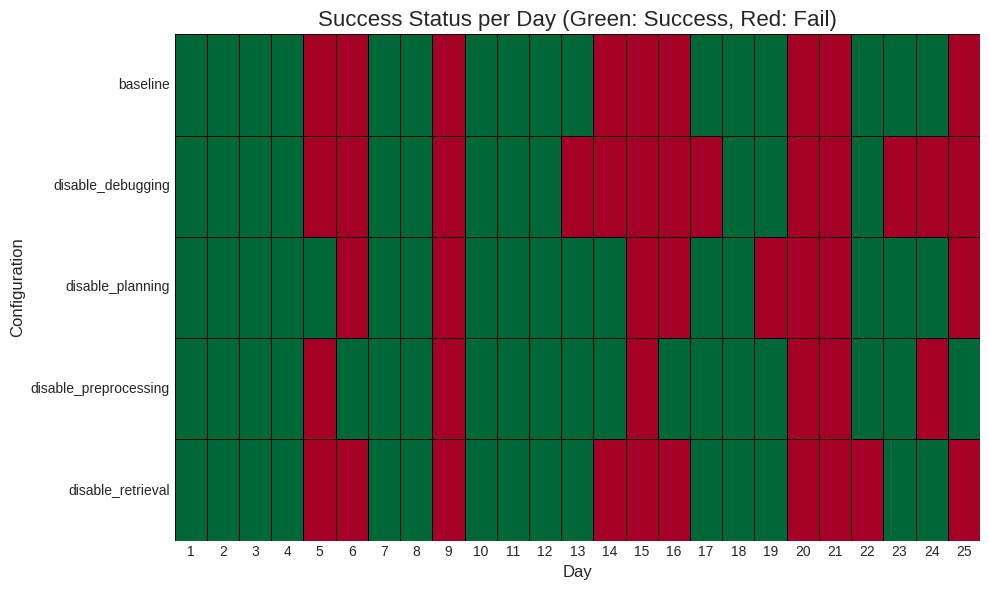

In [ ]:
# Convert success boolean to integer (1 for True, 0 for False) for color mapping
success_data_pivot = df.pivot_table(
    index="name", columns="day", values="success", aggfunc="first"
).astype(int)


# Get unique days from the DataFrame to ensure correct labels for x-axis
days = sorted(df['day'].unique())

# --- Plotting Success Heatmap ---
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 6)) # Create a new figure for this plot
ax1 = sns.heatmap(
    success_data_pivot,
    annot=False,     # No annotations for 0/1 values
    fmt=".0f",
    cmap="RdYlGn",   # Red for fail (0), Green for success (1)
    cbar=False,      # No color bar for binary values
    linewidths=0.5,
    linecolor="black",
)
ax1.set_title("Success Status per Day (Green: Success, Red: Fail)", fontsize=16)
ax1.set_ylabel("Configuration", fontsize=12)
ax1.set_xlabel("Day", fontsize=12) # Explicitly set x-axis label
ax1.tick_params(axis='y', rotation=0) # Keep y-axis labels horizontal

# Set x-axis ticks and labels for this plot
ax1.set_xticks([i + 0.5 for i in range(len(days))])
ax1.set_xticklabels(days)
ax1.tick_params(axis='x', rotation=0) # Keep x-axis labels horizontal

plt.tight_layout()
plt.show()

Success rates for challenging days (9, 15, 20, 21):
name
baseline                 0.0
disable_debugging        0.0
disable_planning         0.0
disable_preprocessing    0.0
disable_retrieval        0.0
Name: success, dtype: float64


Common keywords and concepts in challenging puzzles:
Day 9:
  Top Keywords: checksum (4), string manipulation (4), disk compaction (3), simulation (2), disk defragmentation (1)
  Top Concepts: simulation (4), parsing (4), arithmetic (4)

Day 15:
  Top Keywords: GPS coordinates (4), box pushing (4), robot simulation (3), grid (3), warehouse (2)
  Top Concepts: simulation (3), state update (2), coordinate geometry (1), state transition (1), conditional logic (1)

Day 20:
  Top Keywords: optimization (4), shortest path (4), grid traversal (4), pathfinding (4), cheating (3)
  Top Concepts: breadth-first search (4), dynamic programming (3), A* search (2), A* (1), combinatorial search (1)

Day 21:
  Top Keywords: shortest path (4), string manipulation (4), keypa

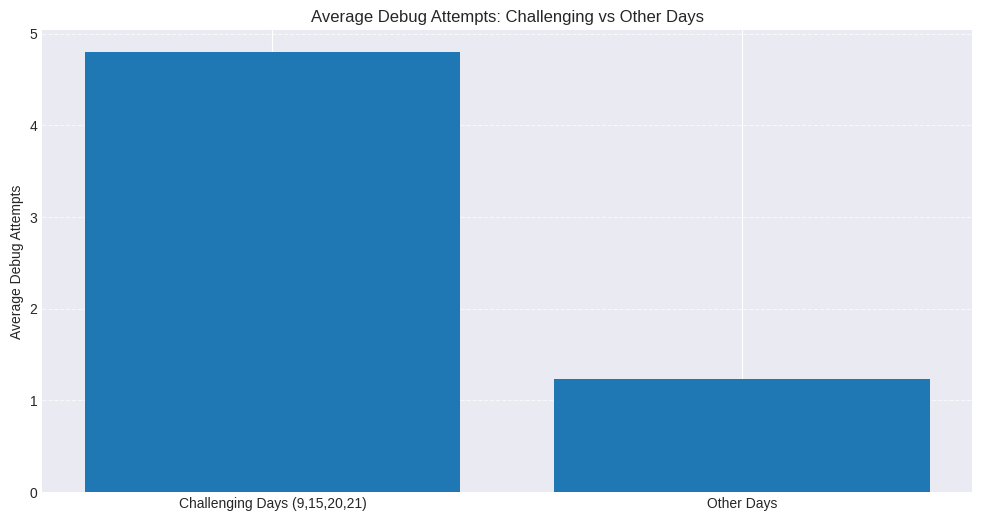

In [15]:
# Filter data for the challenging days (9, 15, 20, 21)
challenging_days = [9, 15, 20, 21]
challenging_puzzles = df[df['day'].isin(challenging_days)]

# Check success rates for these days across configurations
success_rates_by_config = challenging_puzzles.groupby('name')['success'].mean() * 100
print("Success rates for challenging days (9, 15, 20, 21):")
print(success_rates_by_config)
print("\n")

# Extract keywords and concepts for these days
print("Common keywords and concepts in challenging puzzles:")
keywords_data = {}
concepts_data = {}

for day in challenging_days:
    day_data = df[df['day'] == day]
    all_keywords = []
    all_concepts = []
    
    for _, row in day_data.iterrows():
        if isinstance(row['keywords'], str):
            all_keywords.extend([k.strip() for k in row['keywords'].split(',')])
        if isinstance(row['concepts'], str):
            all_concepts.extend([c.strip() for c in row['concepts'].split(',')])
    
    # Count frequencies
    keyword_freq = {k: all_keywords.count(k) for k in set(all_keywords) if k}
    concept_freq = {c: all_concepts.count(c) for c in set(all_concepts) if c}
    
    # Store top keywords and concepts
    keywords_data[day] = sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)[:5]
    concepts_data[day] = sorted(concept_freq.items(), key=lambda x: x[1], reverse=True)[:5]

# Display top keywords and concepts for each challenging day
for day in challenging_days:
    print(f"Day {day}:")
    print("  Top Keywords:", ', '.join([f"{k[0]} ({k[1]})" for k in keywords_data[day]]))
    print("  Top Concepts:", ', '.join([f"{c[0]} ({c[1]})" for c in concepts_data[day]]))
    print()

# Compare debug attempts between challenging days and other days
plt.figure(figsize=(12, 6))
avg_debug_challenging = df[df['day'].isin(challenging_days)]['debug_attempts'].mean()
avg_debug_other = df[~df['day'].isin(challenging_days)]['debug_attempts'].mean()

plt.bar(['Challenging Days (9,15,20,21)', 'Other Days'], 
        [avg_debug_challenging, avg_debug_other])
plt.title('Average Debug Attempts: Challenging vs Other Days')
plt.ylabel('Average Debug Attempts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

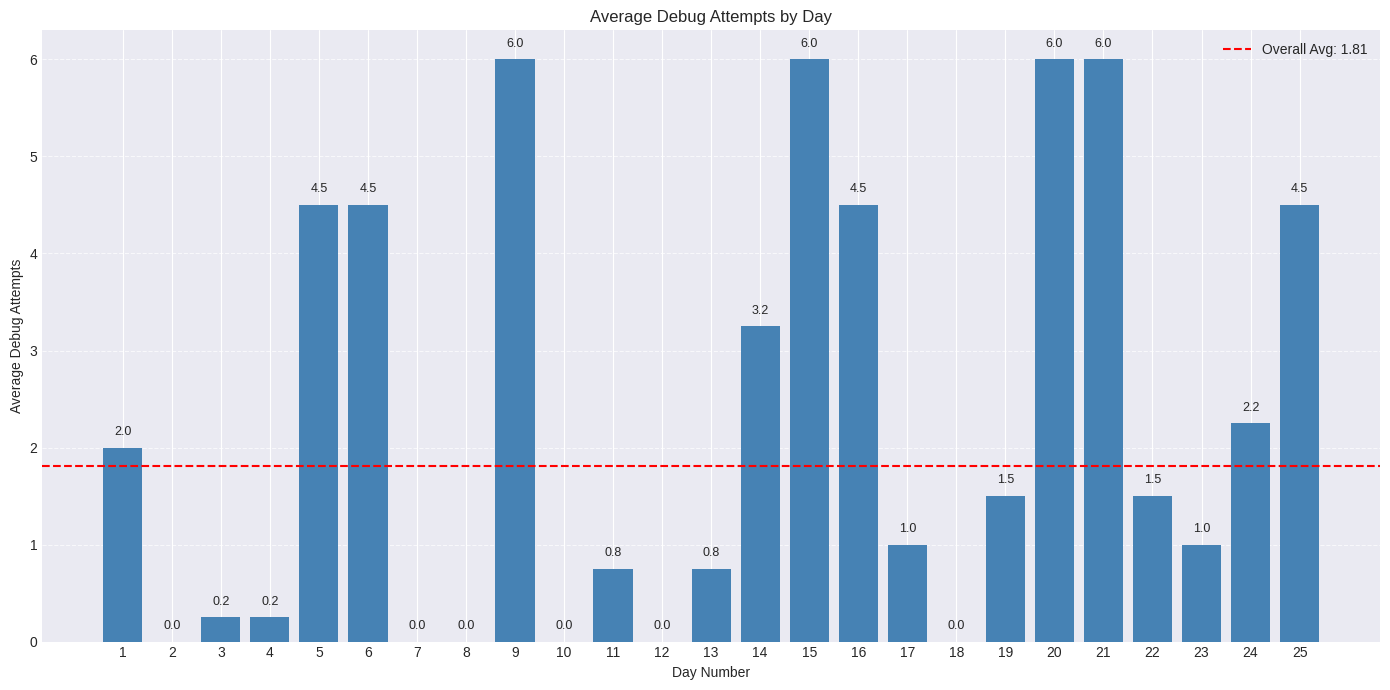

In [16]:
# Visualize average debug attempts per day across all configurations
avg_debug_by_day = df[df['name'] != 'disable_debugging'].groupby('day')['debug_attempts'].mean().sort_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(avg_debug_by_day.index, avg_debug_by_day.values, color='steelblue')

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Day Number')
plt.ylabel('Average Debug Attempts')
plt.title('Average Debug Attempts by Day')
plt.xticks(range(1, 26))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add horizontal line for overall average
overall_avg = df['debug_attempts'].mean()
plt.axhline(y=overall_avg, color='r', linestyle='--', label=f'Overall Avg: {overall_avg:.2f}')
plt.legend()


plt.tight_layout()
plt.show()

### Debugging

Which puzzles required the most debug attemps? And in which configuration was this?

In [17]:
# Find the rows with the maximum number of debug attempts
max_debug_attempts = df['debug_attempts'].max()
most_debugged_puzzles = df[df['debug_attempts'] == max_debug_attempts][['day', 'name', 'debug_attempts', 'success']]